In [1]:
import pandas as pd
from pandas_indexing import isin, concat
import pandas_indexing.accessors
from dominate.tags import div
from dominate import document
from concordia import embed_image, add_sticky_toc
from concordia.report import HEADING_TAGS
import seaborn as sns
from tqdm import tqdm

In [2]:
version = "2023-07-11"

In [3]:
data = pd.read_csv(f"harmonization-{version}.csv", index_col=list(range(5))).rename(
    columns=int
)
model = data.idx.extract(
    variable="Emissions|{gas}|{sector}|Unharmonized", drop=True
).dropna(how="all", axis=1)
harm = data.idx.extract(
    variable="Emissions|{gas}|{sector}|Harmonized|{method}", drop=True
).dropna(how="all", axis=1)
hist = (
    data.loc[isin(model="CEDS")]
    .idx.extract(variable="Emissions|{gas}|{sector}", drop=True)
    .dropna(how="all", axis=1)
    .idx.dropna(subset="region")
)

In [4]:
def make_totals(df):
    original_levels = df.index.names
    if 'method' in original_levels: # need to process harm
        df = df.droplevel('method')
    level = df.index.names
    ret = pd.concat([
        (
            df
            .loc[~isin(region='World')] # don't count aviation
            .groupby(level=list(set(level) - set(['region'])))
            .sum()
            .idx.assign(region="World", order=level)
        ), 
        (
            df
            .groupby(level=list(set(level) - set(['region', 'sector'])))
            .sum()
            .idx.assign(region='World', sector='Total', order=level)
        )
    ])
    if 'method' in original_levels: # need to process harm
        ret = ret.idx.assign(method="aggregate", order=original_levels)
    return ret

harm = pd.concat([harm, make_totals(harm)])
model = pd.concat([model, make_totals(model)])
hist = pd.concat([hist, make_totals(hist)])

In [21]:
def plot_harm(sel, levels=["gas", "sector", "region"]):
    h = harm.loc[sel]
    data = concat(
        dict(
            CEDS=hist.loc[sel],
            Unharmonized=model.loc[sel],
            Harmonized=h.droplevel("method"),
        ),
        keys="key",
    ).loc[:, 2000:]

    non_uniques = [lvl for lvl in levels if len(h.idx.unique(lvl)) > 1]
    if not non_uniques:
        method = h.idx.unique("method").item()
        return data.T.plot(
            ylabel=data.idx.unique("unit").item(),
            title=" - ".join(data.idx.unique(["gas", "sector", "region"]).item())
            + f": {method}",
            legend=False,
        )

    (non_unique,) = non_uniques
    g = sns.relplot(
        data.rename_axis(columns="year").stack().to_frame("value").reset_index(),
        kind="line",
        x="year",
        y="value",
        col=non_unique,
        col_wrap=4,
        hue="key",
        facet_kws=dict(sharey=False),
        legend=False,
        height=2,
        aspect=1.5
    ).set(ylabel=data.pix.unique("unit").item())
    return g

<Axes: title={'center': 'CO2 - Total - World: aggregate'}, ylabel='Mt CO2/yr'>

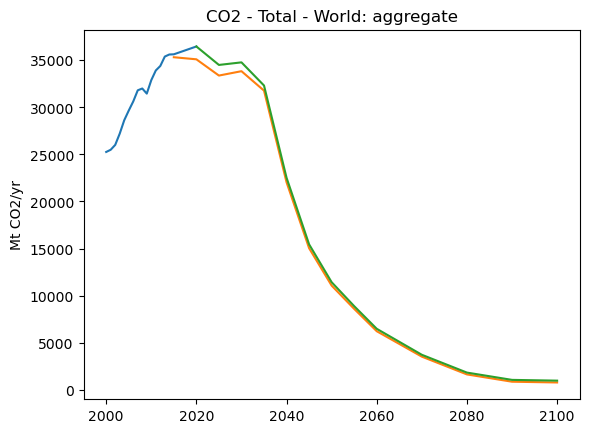

In [6]:
plot_harm(isin(region="World", sector="Total", gas="CO2"))

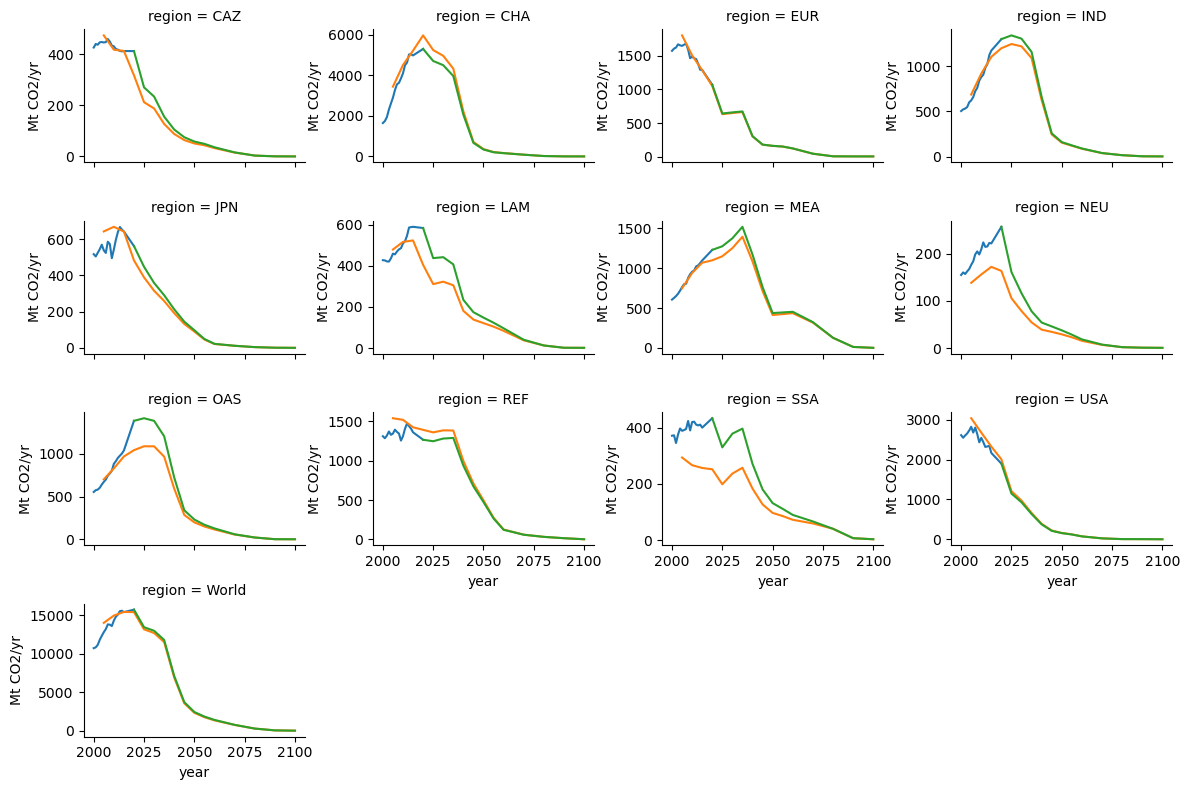

In [22]:
plot_harm(isin(sector="Energy Sector", gas="CO2"))

# Make Comparison Notebooks

In [8]:
def what_changed(next, prev):
    length = len(next)
    if prev is None:
        return range(length)
    for i in range(len(next)):
        if prev[i] != next[i]:
            return range(i, length)

In [28]:
def make_doc(order):
    ((m, s),) = harm.idx.unique(["model", "scenario"])

    index = harm.index.idx.unique(order).sort_values()
    doc = document(title=f"Harmonization results: {m} - {s}")

    main = doc.add(div())
    prev_idx = None
    for idx in tqdm(index):
        main.add([HEADING_TAGS[i](idx[i]) for i in what_changed(idx, prev_idx)])

        ax = plot_harm(isin(**dict(zip(index.names, idx)), ignore_missing_levels=True))
        main.add(embed_image(ax, close=True))

        prev_idx = idx

    add_sticky_toc(doc, max_level=2, compact=True) 
    return doc

In [16]:
with open(f"harmonization-{version}-single.html", "w", encoding="utf-8") as f:
    print(make_doc(order=["gas", "sector", "region"]), file=f)

100%|██████████| 833/833 [02:23<00:00,  5.80it/s]


In [29]:
with open(f"harmonization-{version}-facet.html", "w", encoding="utf-8") as f:
    print(make_doc(order=["gas", "sector"]), file=f)

  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 89/89 [03:41<00:00,  2.49s/it]


In [27]:
!open harmonization-{version}-facet.html